In [1]:
import pandas as pd
import glob

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns

import numpy as np
import itertools
from urllib.parse import urlparse

import more_itertools as mit
import validators
import json

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Image label')
    plt.xlabel('Media label')
    plt.tight_layout()

In [3]:
DIR = '../../data/processed'
crawls = glob.glob('{}/media_*.csv'.format(DIR))
last_crawl = sorted(crawls)[-1]
df = pd.read_csv(last_crawl)

In [4]:
last_crawl

'../../data/processed/media_2019-02-02 15:59:21.csv'

In [5]:
df['label'].unique()

array(['mixture', 'false', 'true'], dtype=object)

In [6]:
scores = {}
cm = [ [ 0 for i in range(3) ] for j in range(3) ]
labels = ['mixture', 'true', 'false']
for i, img_label in enumerate(labels):
    for j, perc in enumerate(['mixed_perc', 'true_perc', 'false_perc']):
        val = sum(df[df.label==img_label][perc])
        scores[img_label+'_image_'+perc] = val
        cm[i][j] = val

In [7]:
scores

{'mixture_image_mixed_perc': 39.29640725376659,
 'mixture_image_true_perc': 79.98330243712729,
 'mixture_image_false_perc': 14.0577903091061,
 'true_image_mixed_perc': 29.95277641560602,
 'true_image_true_perc': 75.9656579278283,
 'true_image_false_perc': 6.81489898989899,
 'false_image_mixed_perc': 69.82972387090034,
 'false_image_true_perc': 140.28388335520688,
 'false_image_false_perc': 18.207226107226106}

In [8]:
sum(scores.values())

474.39166666666665

In [9]:
plot_confusion_matrix(np.array(cm), labels)

Confusion matrix, without normalization
[[ 39.29640725  79.98330244  14.05779031]
 [ 29.95277642  75.96565793   6.81489899]
 [ 69.82972387 140.28388336  18.20722611]]


Normalized confusion matrix
[[0.29471384 0.59985602 0.10543013]
 [0.26569583 0.67385267 0.0604515 ]
 [0.30584035 0.61441561 0.07974404]]


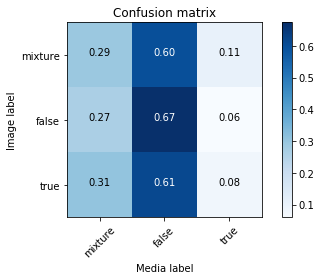

In [10]:
plot_confusion_matrix(np.array(cm), df['label'].unique(), True)

In [11]:
with open('{}/factuality.json'.format(DIR)) as f:
    media_labels = json.load(f)

In [12]:
def clean_url(url):
    return urlparse(url).netloc.replace('www.', '')


def get_label(url: str) -> str:
    if not validators.url(url):
        return 'INVALID'
    
    url = clean_url(url)
    if url in media_labels:
        return media_labels[url]
    return 'UNKNOWN'

In [17]:
def print_media_labels(url_caption, urls):
    print('https://www.snopes.com/fact-check/{}'.format(url_caption))
    for url in urls:
        label = get_label(url)
        if label != 'UNKNOWN' and label != 'INVALID':
            print('{} : {}'.format(url, label))
    print('-----------------')

In [14]:
df.legal_page_urls = df.legal_page_urls.apply(lambda x: [y.strip(' \'"') for y in str(x)[1:-1].split(',')])

In [15]:
true_media_false_img = df[(df.label=='false') & (df.true_perc == 1)]

In [16]:
true_media_false_img.shape

(96, 15)

In [29]:
claims = [('https://www.thestar.com/news/world/analysis/2018/09/12/trump-set-a-new-dishonesty-record-in-august-his-third-straight-record-month.html',
          "President Trump's notorious 'fist pump' at a Pennsylvania airport on 9/11 was offered as a greeting to a cancer victim.",
          'unrelated'),
         ('https://www.wral.com/man-suspected-of-mailing-pipe-bombs-has-nc-ties/17948943/',
         'A photograph of Cesar Sayoc and Israel "Izzy" Hernandez is evidence of a Democrat-orchestrated "false flag" operation.',
         'unrelated'),
         ('https://www.nytimes.com/2017/06/28/magazine/greetings-et-please-dont-murder-us.html',
         'A photograph shows Carl Sagan holding a sign reading "No Billboards in Space."',
         'unrelated'),
          ('https://www.npr.org/templates/story/story.php?storyId=102294844',
           'Photograph shows a tornado that hit Rome, Georgia, in March 2012',
           'unrelated'),
          
         ('https://www.dailyherald.com/news/20180804/facts-matter-rival-animals-not-at-watering-hole-the-true-trump-golf-figures',
         'A photograph shows a lion and a zebra peacefully drinking together at a watering hole.',
         'disagree'),
         ('https://www.independent.co.uk/news/world/asia/kathmandu-plane-crash-airport-us-bangla-airlines-nepal-runway-deaths-smoke-a8251346.html',
         'Images show the aftermath of a plane crash in Havana, Cuba in May 2018.',
         'disagree'),
         ('https://www.charlotteobserver.com/news/local/article201029909.html',
         'A photograph shows a twenty-foot-long shark that washed up on a beach in Kitty Hawk, North Carolina.',
         'disagree'),
         ('https://www.tampabay.com/florida-politics/buzz/2017/09/10/white-house-social-media-director-tweets-then-deletes-misinformation-as-irma-hits-florida/',
         'A video shows Hurricane Irma hitting Miami International Airport.',
         'disagree'),
          ('https://www.mediaite.com/online/no-nicolle-wallaces-msnbc-show-did-not-air-a-trump-worried-about-pecker-leaking-chyron/',
          'A screenshot from an MSNBC broadcast captures a chyron reading "Trump Worried About Pecker Leaking."',
          'disagree'),
          ('https://newsone.com/3052993/magic-johnson-donates-blood-hoax/',
          'HIV-positive basketball star Earvin "Magic" Johnson donated blood to patients with leukemia.',
          'disagree'),
          ('https://www.straitstimes.com/singapore/halal-pork-label-an-insensitive-hoax-fairprice',
          'Photograph shows a package of NTUC FairPrice pork labeled as halal.',
          'disagree'),
          ('https://www.gizmodo.com.au/2016/12/69-viral-images-from-2016-that-were-totally-fake/',
          'Chipotle create a “never forget” ad reminiscent of the 9/11 attacks featuring burritos in the place of the Twin Towers?',
          'disagree'),
          
         ('https://www.huffingtonpost.com/entry/charlie-chaplin-was-the-distracted-boyfriend-meme-before-the-meme_us_5b1e9614e4b09d7a3d7569bb',
         'A still from a 1920s Charlie Chaplin silent film resembles an online meme popularized nearly a century later.',
         'agree'),
         ('https://www.sbs.com.au/guide/article/2018/09/05/step-ring-big-hearted-andre-giant',
         'A photograph shows André the Giant holding a 12-oz. can of beer.',
         'agree'),
         ('https://theconservativetreehouse.com/2011/12/23/veterans-day-at-lambeau-field-11-14-11-this-was-censored-by-espn/',
         'Photographs show a 2011 NFL Veterans Day tribute that ESPN omitted from their pre-game coverage.',
         'agree'),
         ('http://www.teapartytribune.com/2018/06/11/two-acts-of-treason-obama-style/',
         'A photograph shows President Barack Obama bowing to Iran\'s supreme leader Ali Khamenei.',
         'agree'),
          ('https://www.theguardian.com/science/2018/feb/07/space-oddity-elon-musk-spacex-car-mars-falcon-heavy',
          'A series of images show a Tesla vehicle in space.',
          'agree'),
         ('https://www.military.com/undertheradar/2017/11/u-s-government-really-deport-veterans',
         'A photograph shows a group of deported U.S. veterans in the Mexican border city of Ciudad Juárez.',
         'agree'),
         ('https://inews.co.uk/culture/television/history-naughty-things-childrens-kids-tv/',
         'A crude sketch of a phallus could be seen on the inside of a log during an episode of Maya the Bee.',
         'agree'),
         ('https://qz.com/874701/photo-carrie-fisher-watching-debbie-reynolds-onstage-is-every-child-watching-their-mom-at-work/',
         'A photograph shows a young Carrie Fisher watching her mother Debbie Reynolds perform onstage.',
         'agree')]

In [30]:
len(claims)

20

In [ ]:
claims = [         
    ('https://www.firstpost.com/entertainment/black-panther-targeted-by-twitter-trolls-who-claim-they-were-assaulted-while-watching-film-4360973.html',
     'White people have been attacked by black filmgoers at showings of "Black Panther."',
     'disagree'),
    ('https://www.thatsnonsense.com/fake-photo-spreads-showing-kim-jong-un-reading-fire-fury/',
    'A photograph shows North Korea leader Kim Jong-un laughing as he reads the book Fire and Fury: Inside the Trump White House.',
    'disagree'),    
    ('https://www.thatsnonsense.com/photo-dog-pooping-outside-10-downing-street-real/',
    'A photograph shows a dog defecating on the steps of 10 Downing Street.',
    'disagree'),
    ('https://www.thatsnonsense.com/twitter-post-coyote-mistaken-lost-dog-not-real/',
    'A photograph shows a coyote being given a bath after it was mistaken by a dog by an Ohio family in October 2017.',
    'disagree'),
    ('https://abc11.com/society/pier-officials-viral-photo-of-waves-at-outer-banks-not-real/2435880/',
    'A photograph shows a 30-foot wave from Hurricane Jose hitting Jennette\'s Pier in North Carolina.',
    'disagree'),
    
    ('https://www.goodnewsnetwork.org/two-cops-do-their-duty-by-doing-the-dishes-when-it-counts-most/',
    'Two police officers cooked a meal and washed the dishes for a group of children after their mother was taken to the hospital.',
    'agree'),
    ('https://www.denverpost.com/2018/02/06/spacex-rocket-launch/',
    'A series of images show a Tesla vehicle in space.',
    'agree'),
    ('https://metro.co.uk/2015/11/22/ladybirds-inside-a-dogs-mouth-are-scaring-the-hell-out-of-people-5519167/',
    'A photograph shows insects embedded in a dog\'s mouth.',
    'agree'),
    ('The streets in some parts of Dhaka, Bangladesh were awash in bloody water after mass animal sacrifices took place on the Islamic holiday Eid al-Adha.',
    'https://www.hindustantimes.com/world-news/when-a-river-of-blood-ran-through-dhaka-after-eid-animal-sacrifices/story-uNQSfw8JMMp0OQDb3Hc8jK.html',
    'agree'),
    ('https://www.engadget.com/2008/06/26/microsoft-then-and-now/',
    'Photograph shows eleven original staff members of Microsoft in 1978.',
    'agree'),
    ('https://nationalpost.com/news/large-alligator-turns-florida-golf-course-into-jurassic-park',
    'A video shows a giant alligator walking across a Florida golf course.',
    'agree')
    
]

In [19]:
for x in true_media_false_img.iloc[:20].iterrows():
    print(x[1].claim)
    print_media_labels(x[1].url_caption, x[1].legal_page_urls)

A photograph shows a woman snorting cocaine with her toddler.
https://www.snopes.com/fact-check/mother-toddler-cocaine
https://heavy.com/news/2012/12/woman-busted-with-cocaine-filled-breast-implants-had-fresh-scars/ : TRUE
https://nation.com.pk/10-Aug-2018/norway-to-test-free-heroin-for-drug-addicts : TRUE
-----------------
A photograph of Cesar Sayoc and Israel "Izzy" Hernandez is evidence of a Democrat-orchestrated "false flag" operation.
https://www.snopes.com/fact-check/cesar-sayoc-izzy-hernandez
https://www.wral.com/man-suspected-of-mailing-pipe-bombs-has-nc-ties/17948943/ : TRUE
https://www.wral.com/man-suspected-of-mailing-pipe-bombs-has-nc-ties/17948943/?fbclid=IwAR1nvVYS_pCkc5m8Hpw_xEgY9sA73kcOK47Vow2fn2ZNh_hAMnHprMpNJTM&comment_order=forward : TRUE
-----------------
Photographs show Dr. Christine Blasey Ford with George Soros, Harvey Weinstein, and Bill Clinton.
https://www.snopes.com/fact-check/ford-george-soros
https://www.nytimes.com/2018/11/04/us/politics/election-misinfo

## True media, which is actually bad/not a media:
- https://www.scoopnest.com/user/Channel4/1050350981949612032-30-years-ago-sergeant-al-powell-helped-save-dozens-of-lives-after-being-sent-to-investigate-a-prank-call-at-nakatomi-plaza-as-we-do-every-year-we-honour-his-bravery-by-showing-the-celebrated-documentary-die-hard-this-saturday-at-1115-pm
- https://knowyourmeme.com/photos/1041235-marijuana-stoner
- https://www.express.co.uk/news/weird/1044814/Egypt-great-pyramid-giza-bombshell-discovery-spt



## Article not directly related to claim
- https://www.snopes.com/fact-check/trump-fistpump-cancer-greeting/ -------------
  https://www.thestar.com/news/world/analysis/2018/09/12/trump-set-a-new-dishonesty-record-in-august-his-third-straight-record-month.html
- https://www.snopes.com/fact-check/cesar-sayoc-izzy-hernandez/ -------- https://www.wral.com/man-suspected-of-mailing-pipe-bombs-has-nc-ties/17948943/
- https://www.snopes.com/fact-check/lenticular-cloud-over-pyramids/ ----------------- https://metro.co.uk/2018/01/15/alien-throne-made-metal-hidden-inside-great-pyramid-7229482/
- https://www.snopes.com/fact-check/putin-obama-tie-pull/ ---- https://www.gq.com/gallery/favorite-pete-souza-photos-throughout-the-obama-years?verso=true
- https://www.snopes.com/fact-check/teenage-daughter-shirt-pregnant/ ----- https://metro.co.uk/2015/04/23/dad-makes-his-daughter-a-t-shirt-with-his-muscly-picture-on-it-to-scare-the-boys-away-5162908/
- https://www.snopes.com/fact-check/hermit-crab-using-skull-shell ------------
https://www.bustle.com/anuj


## Article disproves claim
- https://www.snopes.com/fact-check/aerial-view-abandoned-plane/ ----- https://www.msn.com/en-us/lifestyle/lifestyle-buzz/this-drone-photographer-reveals-amazing-patterns/ss-BBNb2Qa?%25253Bocid=mailsignoutmd#image=2
- https://www.snopes.com/fact-check/zebra-lion-watering-hole/ ----- https://www.dailyherald.com/news/20180804/facts-matter-rival-animals-not-at-watering-hole-the-true-trump-golf-figures
- https://www.snopes.com/fact-check/sign-starbucks-racial-bias-training-single-white-people/ ----- https://www.metro.us/lifestyle/food-and-drinks/starbucks-patrons-of-color-line-hoax
- https://www.snopes.com/fact-check/is-this-plane-crash-havana-cuba -----
https://www.independent.co.uk/news/world/asia/kathmandu-plane-crash-airport-us-bangla-airlines-nepal-runway-deaths-smoke-a8251346.html : 
https://www.irishtimes.com/news/world/asia-pacific/at-least-49-confirmed-dead-after-plane-crash-at-nepal-airport-1.3423852 : 
https://nationalpost.com/pmn/news-pmn/49-dead-from-plane-that-crashed-while-landing-in-nepal : TRUE
https://www.deseretnews.com/article/900012704/plane-carrying-71-people-crashes-catches-fire-in-kathmandu.html : 
- https://www.snopes.com/fact-check/did-huge-shark-wash-up-kitty-hawk/ ------------- https://www.charlotteobserver.com/news/local/article201029909.html
- https://www.snopes.com/fact-check/are-white-people-being-assaulted-at-showing-of-black-panther/ ------------ https://www.firstpost.com/entertainment/black-panther-targeted-by-twitter-trolls-who-claim-they-were-assaulted-while-watching-film-4360973.html
- https://www.snopes.com/fact-check/hurricane-jose-30-foot-waves-jennettes-pier/ ------------ https://abc11.com/society/pier-officials-viral-photo-of-waves-at-outer-banks-not-real/2435880/; https://www.thatsnonsense.com/fake-viral-photo-shows-30-feet-waves-crashing-jennette-pier-north-carolina/
- https://www.snopes.com/fact-check/hurricane-irma-hitting-miami-airport/ --------- https://www.tampabay.com/florida-politics/buzz/2017/09/10/white-house-social-media-director-tweets-then-deletes-misinformation-as-irma-hits-florida/
- https://www.snopes.com/fact-check/hurricane-now-contains-sharks/ ------------ https://globalnews.ca/news/3718173/hurricane-irma-isnt-sucking-up-sharks-as-far-as-we-know/


## Actual false article on a true media
- https://www.snopes.com/fact-check/president-obama-bow-ayatollah-khamenei/ ------------- http://www.teapartytribune.com/2018/06/11/two-acts-of-treason-obama-style/


## Article contains a different image:
- https://www.snopes.com/fact-check/is-this-carl-sagan-holding-a-no-billboards-in-space-sign/ ---------- https://www.nytimes.com/2017/06/28/magazine/greetings-et-please-dont-murder-us.html
- https://www.snopes.com/fact-check/dog-defecate-10-downing-street/ ----------------https://www.bbc.com/news/in-pictures-23897883
- 

In [20]:
true_media_true_img = df[(df.label=='true') & (df.true_perc == 1)]

In [21]:
true_media_true_img.shape

(48, 15)

In [22]:
for x in true_media_true_img.iterrows():
    print_media_labels(x[1].url_caption, x[1].legal_page_urls)

https://www.snopes.com/fact-check/i40-north-carolina-underwater
https://www.greensboro.com/news/north_carolina/don-t-trust-gps-navigation-apps-in-eastern-nc-you/article_694a862d-51f5-5efa-a69e-dac5c2abb67b.html : TRUE
https://www.greensboro.com/drone-footage-shows-submerged-interstate-in-flood-hit-pender-county/html_82e31663-abf6-52eb-beec-686d311a4238.html : TRUE
https://www.journalnow.com/drone-footage-shows-submerged-interstate-in-flood-hit-pender-county/html_bfb455ee-41d3-545e-becd-98aede686c73.html : TRUE
-----------------
https://www.snopes.com/fact-check/officers-cook-dinner-children
https://www.goodnewsnetwork.org/tag/netherlands/ : TRUE
https://www.goodnewsnetwork.org/two-cops-do-their-duty-by-doing-the-dishes-when-it-counts-most/ : TRUE
https://www.goodnewsnetwork.org/tag/law-enforcement/page/4/ : TRUE
https://www.goodnewsnetwork.org/tag/kindness/page/45/ : TRUE
-----------------
https://www.snopes.com/fact-check/distracted-boyfriend-meme-come-real-movie
https://www.stuff.co.

In [88]:
invalid_urls = df.legal_page_urls.apply(lambda urls: [url for url in urls if not validators.url(url)])

In [90]:
invalid_urls = list(mit.flatten(invalid_urls))

In [93]:
invalid_urls

['-the-democrats',
 '-and-that-white-christian-vote/10585872',
 'http://www.xn--fciles-pta.com/2018/09/',
 'okiem-strazaka-zdjecie-z-wypadku-samochod-przebity-barierka',
 '_Lee_-_IMAT_101-_FCC_Trng_6-25-09.pdf',
 '21664855',
 '21215351',
 '21214270',
 '21225294',
 '21220884',
 'https://xn--80ahgjjbf0cj.xn--p1ai/ghost-caught-on-camera_670b142aa.html',
 'https://xn--80ahgjjbf0cj.xn--p1ai/ghost-caught-on-camera-5-most-haunted-places_3d23727b7.html',
 '1',
 '1311913055-zhest-download-by-lokki.html',
 '18267024',
 '17729195',
 '17729195',
 '17043372',
 '13025997',
 'za-miecz-podniesiony-nad-polska-kula-w-leb',
 'kula-lis-67',
 '619',
 '2&cmpid=kidrock/wrap-function/page/8',
 '13194593',
 '3848004',
 '3847813',
 '611ee5e4cc3ad7a0003b974c9169a676frqlo7db.html',
 '-prosti%E2%80%A6',
 '18230833',
 '18267286',
 '2086570',
 '18659013',
 '19226874',
 '13233662',
 'http://x--x.xyz/?p=15204',
 '1139338623',
 'newer',
 '11804040',
 '15967746',
 '13660344',
 'rabbit/page/22/',
 'rabbit/page/22/',
 '19

In [96]:
unknown_urls = df.legal_page_urls.apply(lambda urls: [get_domain(url) for url in urls if get_label(url) == 'UNKNOWN' and validators.url(url)])

In [97]:
unknown_urls = list(mit.flatten(unknown_urls))

In [105]:
unknown_counts = pd.Series(unknown_urls).value_counts().rename_axis('url').reset_index(name='count')

In [106]:
unknown_counts.to_csv('../../data/external/unknown_media.csv', index=False)

In [110]:
list(df[df.url_caption == 'putin-obama-tie-pull'].legal_page_urls)

[['https://www.wusa9.com/article/news/verify-is-this-viral-photo-of-putin-yanking-obamas-tie-real/65-575167821',
  'https://www.10news.com/news/fact-or-fiction/fact-or-fiction-putin-pulled-obama-s-tie-',
  'https://www.13newsnow.com/article/news/local/verify/verify-is-this-viral-photo-of-putin-yanking-obamas-tie-real/291-575284117',
  'https://www.quora.com/Why-did-Putin-grab-Obamas-tie-Was-it-a-friendly-chat-It-certainly-doesnt-look-like-it',
  'https://www.10news.com/news?webSyncID=4071a989-b584-d64b-360a-36b43dd86d00&sessionGUID=511bc3c1-cde9-1066-9756-96c815189c82&00000166-402f-de2e-a1fe-74af9b720008-page=266',
  'https://www.10news.com/news?webSyncID=2de35341-1ecc-d0c1-56b2-3d839c87a1da&sessionGUID=6adc4a33-2892-e334-071a-989b584d64b3&00000166-402f-de2e-a1fe-74af9b720008-page=266',
  'https://www.10news.com/news/fact-or-fiction?00000166-4055-de2e-a1fe-74dd5c030008-page=3',
  'https://www.pinterest.com/pin/147492956527659126/',
  'https://www.pinterest.com/pin/464433780314591814/',